# Markedness in the Library of Congress Subject Headings

### Imports

In [1]:
import pickle as pk
import random
import matplotlib.pyplot as plt 
import numpy as np
import re
import csv
import collections

import spacy 
nlp = spacy.load("en_core_web_sm") 

### Functions

In [15]:
def getNew(term):
    return int(term['yearNew'][:4])

def percent(num, denom):
    if denom == 0:
        return 0
    return num/denom*100

def findTerms(pattern, terms):
    matchedTerms = {}
    for idx, term in terms.items():
        if re.search(pattern, term['heading'].lower()) is not None:
            matchedTerms[idx] = term
    return matchedTerms    

def clean(word, keepBrack=False):
    if keepBrack:
        return word.lower().replace("'", " '").replace(',', '').replace('_', '').replace('-', ' ').strip()
    else:
        return word.lower().replace('(', '').replace(')', '').replace("'", " '").replace(',', '').replace('_', '').replace('-', ' ').strip()

def findPairs(mTerms, wTerms, pairs):
    pairedTerms = []
    indicesW, indicesM = [], []
    mHeads = [t['heading'] for t in mTerms.values()]
    wHeads = [t['heading'] for t in wTerms.values()]
    for i in range(len(pairs)):
        wordM, wordW = pairs[i]
        replaced = {}
        for i, head in enumerate(wHeads):
            wHead = head.lower()
            if wordW in wHead:
                replaced[wHead.replace(wordW, '')] = i
        for i, head in enumerate(mHeads):
            mHead = head.lower()
            if wordM in mHead:
                genTerm = mHead.replace(wordM, '')
                if genTerm in replaced.keys() and i not in indicesM and replaced[genTerm] not in indicesW:
                    pairedTerms.append((list(mTerms.items())[i],list(wTerms.items())[replaced[genTerm]]))
                    indicesM.append(i)
                    indicesW.append(replaced[genTerm])
    return pairedTerms

def getTimeLine(lcsh):
    years = [y for y in range(1986, 2024)]
    timeline = {y:0 for y in years}

    if type(lcsh) is dict:
        lcshIterator = lcsh.values()
    else:
        lcshIterator = lcsh
    for term in lcshIterator:
        yearAdded = getNew(term)
        if yearAdded != 2024:
            timeline[yearAdded] += 1
        if term['yearDep'] is not None:
            yearDep = int(term['yearDep'][:4])
            if yearDep != 2024:
                timeline[yearDep] -= 1
    return timeline
    
def plotStacked(x, yDict, colours, title, xLabel, yLabel):
    width = 0.8
    _, ax = plt.subplots(figsize = (15, 5))
    bottom = np.zeros(len(x))
    i = 0
    for lab, counts in yDict.items():
        p = ax.bar(x, counts, width, label=lab, bottom=bottom, color=colours[i])
        bottom += counts
        i += 1
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.spines[['right', 'top']].set_visible(False)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xticks(x, rotation=90)
    plt.show()
    

### Load Data

In [3]:
with open('Data/LCSH/lcsh.pickle', 'rb') as f:
    lcsh = pk.load(f)

with open('Data/LCSH/genLCSH-current.pickle', 'rb') as f:
    wTerms, mTerms = pk.load(f)

#### [WOMEN/MEN] in [BLANK]

In [4]:
menIn = findTerms(r'^men in ', mTerms)
womenIn = findTerms(r'^women in ', wTerms)

menInSub = {idx:term for idx, term in menIn.items() if term['bt'] is not None}
womenInSub = {idx:term for idx, term in womenIn.items() if term['bt'] is not None}

matched = findPairs(menInSub, womenInSub, [('men', 'women')])
matchIdxW = [w[0] for _, w in matched]
matchIdxM = [m[0] for m,_ in matched]

print(f'There are {len(menIn)} terms of the form "men in __" and {len(menInSub)} ({percent(len(menInSub), len(menIn)):.2f}%) have a broader term.')
print(f'There are {len(womenIn)} terms of the form "women in __" and {len(womenInSub)} ({percent(len(womenInSub), len(womenIn)):.2f}%) have a broader term.')

menIn_mark = [term for idx, term in menInSub.items() if idx not in matchIdxM]
womenIn_mark = [term for idx, term in womenInSub.items() if idx not in matchIdxW]

print(f'There are {len(menIn_mark)} terms were men are the marked case and {len(womenIn_mark)} where women are. {len(matched)} are paired.')

There are 11 terms of the form "men in __" and 8 (72.73%) have a broader term.
There are 131 terms of the form "women in __" and 121 (92.37%) have a broader term.
There are 0 terms were men are the marked case and 113 where women are. 8 are paired.


The plots below depict the cumulative and relative frequencies of terms for [Men] in [BLANK] versus [Women] in [Blank]

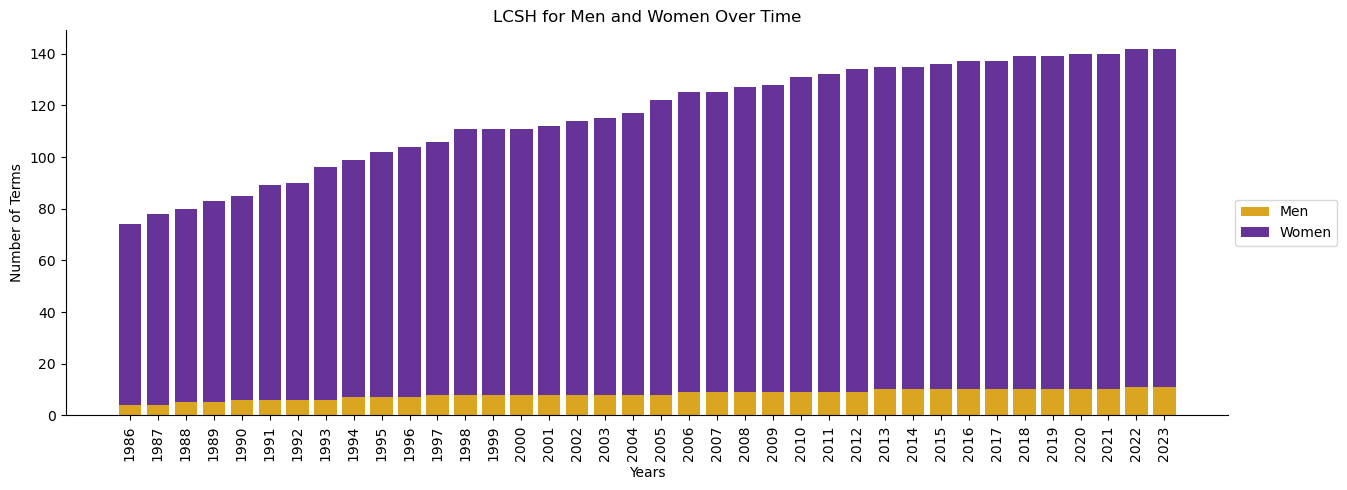

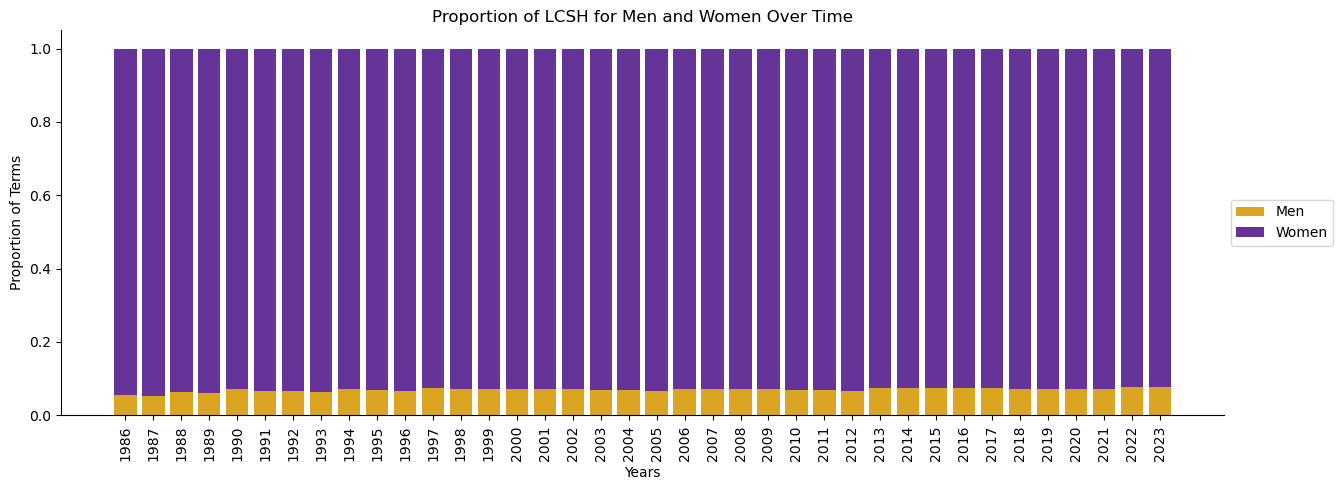

In [17]:
timelineW = getTimeLine(womenIn)
timelineM = getTimeLine(menIn)

culmW = np.cumsum(list(timelineW.values()))
culmM = np.cumsum(list(timelineM.values()))
yData = {
    "Men": culmM,
    "Women": culmW,
}
x = list(timelineM.keys())

colours = ['goldenrod', 'rebeccapurple']
plotStacked(x, yData, colours, 'LCSH for Men and Women Over Time', 'Years', 'Number of Terms')



total = [culmW[i]+culmM[i] for i in range(len(culmM))]
propW = [culmW[i]/total[i] for i in range(len(culmW))]
propM = [culmM[i]/total[i] for i in range(len(culmM))]
yData = {
    "Men": propM,
    "Women": propW,
}
plotStacked(x, yData, colours, 'Proportion of LCSH for Men and Women Over Time', 'Years', 'Proportion of Terms')

[Women/Men] [Noun Phrase]

In [5]:
def checkIdx(idx, lcsh): 
    try: 
        lcsh[idx]
        return True
    except KeyError: 
        return False

In [6]:
def findTermsPOS(pattern, indexWord, terms):
    matchedTerms = {}
    for idx, term in terms.items():
        if re.search(pattern, term['heading'].lower()) is not None:
            words = clean(term['heading'], keepBrack=True).split()
            i = words.index(indexWord) + 1
            pos = nlp(words[i])[0].tag_
            if ('(' not in words[i] 
                    and pos != 'DT' 
                    and pos != 'IN' 
                    and pos != 'CC' 
                    and 'in' not in words
                    and 'on' not in words):
                matchedTerms[idx] = term
    return matchedTerms
            
def getParents(term, lcsh):
    if term['bt'] is not None:
        parents = [lcsh[idx] for idx in term['bt'] if idx.strip()]
    else:
        parents = []
    return parents

def getSiblings(term, parent, lcsh):
    heads = [lcsh[idx]['heading'] for idx in parent['nt'] if idx.strip() and checkIdx(idx, lcsh)]
    if term['heading'] not in heads:
        raise ValueError('Parent LCSH is not the parent of the selected LCSH')
    elif len(heads) == 1:
        return []
    else:
        return [lcsh[idx] for idx in parent['nt'] if idx.strip() and checkIdx(idx, lcsh) and lcsh[idx]['heading'] != term['heading']]    

In [7]:
menBlanks = findTermsPOS(r'^men ', 'men', mTerms)
womenBlanks = findTermsPOS(r'^women ', 'women', wTerms)

menBlanksSub = {idx:term for idx, term in menBlanks.items() if term['bt'] is not None}
womenBlanksSub = {idx:term for idx, term in womenBlanks.items() if term['bt'] is not None}

matchedW = findPairs(menBlanksSub, womenBlanksSub, [('men', 'women')])
matchIdxW_ = [w[0] for _, w in matchedW]
matchIdxM = [m[0] for m,_ in matchedW]

print(f'There are {len(menBlanks)} terms of the form "men __" and {len(menBlanksSub)} ({percent(len(menBlanksSub), len(menBlanks)):.2f}%) have a broader term.')
print(f'There are {len(womenBlanks)} terms of the form "women __" and {len(womenBlanksSub)} ({percent(len(womenBlanksSub), len(womenBlanks)):.2f}%) have a broader term.')

menBlanks_mark = [term for idx, term in menBlanksSub.items() if idx not in matchIdxM]
womenBlanks_mark = [term for idx, term in womenBlanksSub.items() if idx not in matchIdxW_]

print(f'There are {len(menBlanks_mark)} terms were men are the marked case and {len(womenBlanks_mark)} where women are. {len(matchedW)} are paired.')

There are 0 terms of the form "men __" and 0 (0.00%) have a broader term.
There are 925 terms of the form "women __" and 697 (75.35%) have a broader term.
There are 0 terms were men are the marked case and 697 where women are. 0 are paired.


In [9]:
maleBlanks = findTermsPOS(r'^male ', 'male', mTerms)
femaleBlanks = findTermsPOS(r'^female ', 'female', wTerms)

maleBlanksSub = {idx:term for idx, term in maleBlanks.items() if term['bt'] is not None}
femaleBlanksSub = {idx:term for idx, term in femaleBlanks.items() if term['bt'] is not None}

matchedF = findPairs(maleBlanksSub, femaleBlanksSub, [('male', 'female')])

matchIdxW = [w[0] for _, w in matchedF]
matchIdxM_ = [m[0] for m,_ in matchedF]

print(f'There are {len(maleBlanks)} terms of the form "male __" and {len(maleBlanksSub)} ({percent(len(maleBlanksSub), len(maleBlanks)):.2f}%) have a broader term.')
print(f'There are {len(femaleBlanks)} terms of the form "female __" and {len(femaleBlanksSub)} ({percent(len(femaleBlanksSub), len(femaleBlanks)):.2f}%) have a broader term.')

maleBlanks_mark = [term for idx, term in maleBlanksSub.items() if idx not in matchIdxM_]
femaleBlanks_mark = [term for idx, term in femaleBlanksSub.items() if idx not in matchIdxW]

print(f'There are {len(maleBlanks_mark)} terms were men are the marked case and {len(femaleBlanks_mark)} where women are. {len(matchedF)} are paired.')

There are 64 terms of the form "male __" and 61 (95.31%) have a broader term.
There are 23 terms of the form "female __" and 23 (100.00%) have a broader term.
There are 56 terms were men are the marked case and 18 where women are. 5 are paired.


There are pairs of terms where 'male' is matched with 'women' so I'll look at terms for 'men' and 'male' vs 'women' and 'female'

In [10]:
matched = findPairs(maleBlanksSub, womenBlanksSub, [('male', 'women')])
matchIdxW = [w[0] for _, w in matched]
matchIdxM = [m[0] for m,_ in matched]
matched += matchedF + matchedW

mmBlanks_mark = [term for idx, term in maleBlanksSub.items() if idx not in matchIdxM and idx not in matchIdxM_] + menBlanks_mark
wfBlanks_mark = [term for idx, term in womenBlanksSub.items() if idx not in matchIdxW and idx not in matchIdxW_] + femaleBlanks_mark

print(f'There are {len(mmBlanks_mark)} terms were men are the marked case (as male or men) and {len(wfBlanks_mark)} where women are (as women or female). {len(matched)} are paired.')

There are 29 terms were men are the marked case (as male or men) and 688 where women are (as women or female). 32 are paired.


The plots below depict the cumulative and relative frequencies of terms for [Men/Male] [NP] versus [Women/Female] [NP]

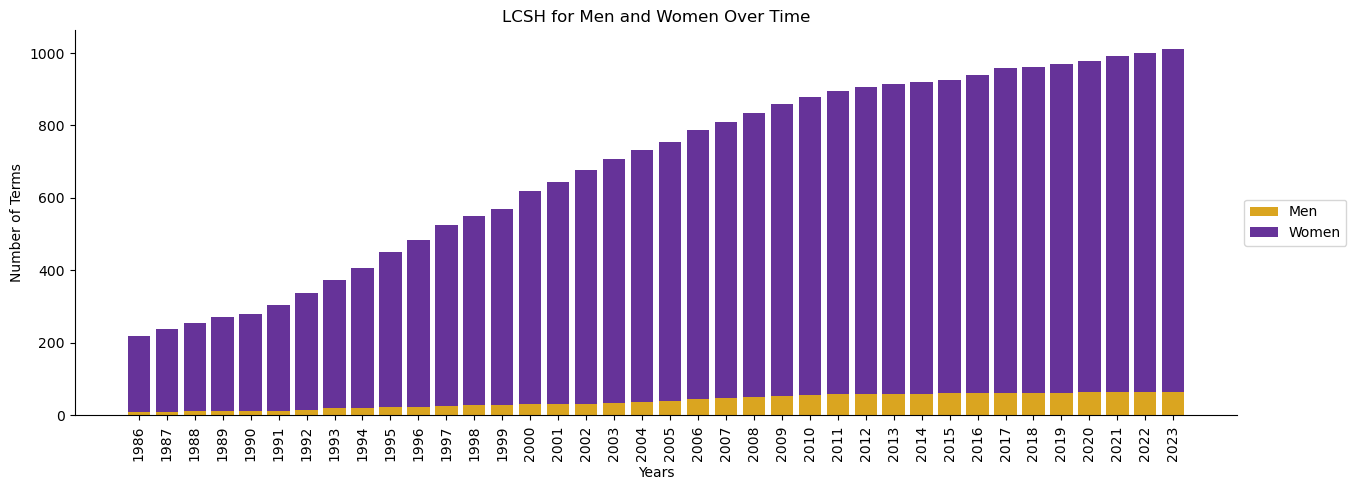

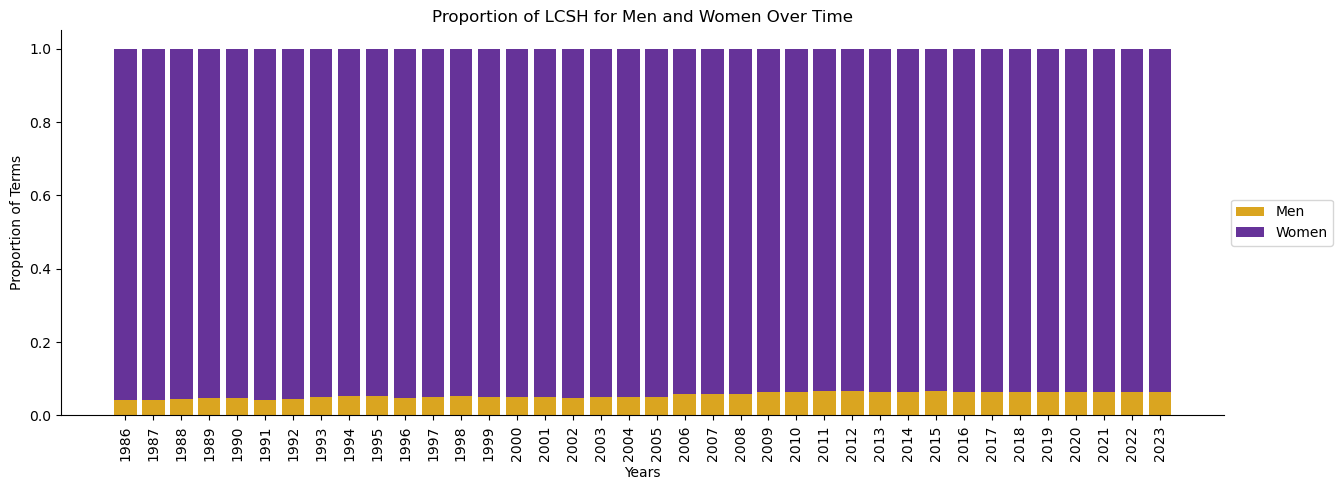

In [18]:
wTerms = {**womenBlanks, **femaleBlanks}
mTerms = {**menBlanks, **maleBlanks}

timelineW = getTimeLine(wTerms)
timelineM = getTimeLine(mTerms)

culmW = np.cumsum(list(timelineW.values()))
culmM = np.cumsum(list(timelineM.values()))
yData = {
    "Men": culmM,
    "Women": culmW,
}
x = list(timelineM.keys())

colours = ['goldenrod', 'rebeccapurple']
plotStacked(x, yData, colours, 'LCSH for Men and Women Over Time', 'Years', 'Number of Terms')



total = [culmW[i]+culmM[i] for i in range(len(culmM))]
propW = [culmW[i]/total[i] for i in range(len(culmW))]
propM = [culmM[i]/total[i] for i in range(len(culmM))]
yData = {
    "Men": propM,
    "Women": propW,
}
plotStacked(x, yData, colours, 'Proportion of LCSH for Men and Women Over Time', 'Years', 'Proportion of Terms')

In [ ]:
with open('Data/markedMen.txt', 'w') as f:   
    for term in mmBlanks_mark:
        parents = getParents(term, lcsh)
        f.write(f'{term['heading']} ({getNew(term)}):\n')
        for i, parent in enumerate(parents):
            f.write(f'\tParent {i+1}: {parent['heading']} ({getNew(parent)})\n')
            parentWords = clean(parent['heading']).split()
            if 'male' not in parentWords and 'men' not in parentWords:
                siblings = getSiblings(term, parent, lcsh)
                if len(siblings) > 0:
                    siblingStr = f'\t\tSiblings:\n'
                    for sibling in siblings:
                        siblingStr = siblingStr + f'\t\t\t{sibling['heading']} ({getNew(sibling)});\n'
                    f.write(siblingStr)
        f.write('\n')

In [ ]:
with open('Data/markedWomen.txt', 'w') as f:   
    for term in wfBlanks_mark:
        parents = getParents(term, lcsh)
        f.write(f'{term['heading']} ({getNew(term)}):\n')
        for i, parent in enumerate(parents):
            f.write(f'\tParent {i+1}: {parent['heading']} ({getNew(parent)})\n')
            parentWords = clean(parent['heading']).split()
            if 'female' not in parentWords and 'women' not in parentWords:
                siblings = getSiblings(term, parent, lcsh)
                if len(siblings) > 0:
                    siblingStr = f'\t\tSiblings:\n'
                    for sibling in siblings:
                        siblingStr = siblingStr + f'\t\t\t{sibling['heading']} ({getNew(sibling)});\n'
                    f.write(siblingStr)
        f.write('\n')

I want to update this to improve my method for finding words that are gendered variants that are obscured because they don't explicitly identify men or women (i.e. male actors and actresses)

In [ ]:
def getGenSpecificTerms(term, siblings, baseWord, replaceWords):
    genSpecific = []
    for sib in siblings:
        if sib['synonyms'] is not None and sib['type'] == 'Topic':
            for word in replaceWords:
                checkTerm = term['heading'].replace(baseWord, word, 1)
                if checkTerm in sib['synonyms']:
                    genSpecific.append(sib)
                    break
    return genSpecific

In [ ]:
for term in wfBlanks_mark:
    parents = getParents(term, lcsh)
    for i, parent in enumerate(parents):
        parentWords = clean(parent['heading']).split()
        if 'female' not in parentWords and 'women' not in parentWords:
            siblings = getSiblings(term, parent, lcsh)
            if len(siblings) > 0:
                specSibs = getGenSpecificTerms(term, siblings, 'Female', ['Men', 'Male']) + getGenSpecificTerms(term, siblings, 'Women', ['Men', 'Male']) 
                if len(specSibs) > 0:
                    print(term['heading'], [s['heading'] for s in specSibs])

In [ ]:
for term in mmBlanks_mark:
    parents = getParents(term, lcsh)
    for i, parent in enumerate(parents):
        parentWords = clean(parent['heading']).split()
        if 'male' not in parentWords and 'men' not in parentWords:
            siblings = getSiblings(term, parent, lcsh)
            if len(siblings) > 0:
                specSibs = getGenSpecificTerms(term, siblings, 'Male', ['Women', 'Female'])
                if len(specSibs) > 0:
                    print(term['heading'], [s['heading'] for s in specSibs])

Male homosexuality ['Lesbianism']
Male actors ['Actresses']
